In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfolio.timeseries import perf_stats

In [2]:
cash = 80000

read backtest results and generate daily returns dataframe

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-24_11-28_20200101_20200731.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
returns = df.cash.resample('B').last().pct_change().dropna()
returns.tail()

time
2020-07-24    0.025915
2020-07-27    0.015808
2020-07-28    0.070475
2020-07-29   -0.038349
2020-07-30   -0.052251
Freq: B, Name: cash, dtype: float64

number of daily return data points:

In [5]:
len(df)

2956

In [6]:
returns.reset_index(drop=True, inplace=True)

# Generate random paths by resampling from returns (with replacements)

change this parameter to get different number of paths

In [7]:
number_of_paths = 500000

In [8]:
simulated_returns = pd.DataFrame(np.random.choice(returns, size=(len(returns), number_of_paths)))

In [9]:
simulated_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
0,-0.004286,-0.023835,0.033384,0.002787,0.002787,-0.014210,0.072219,-0.014195,0.056630,0.001929,...,-0.061355,0.033384,0.003755,-0.000627,0.049475,-0.005515,-0.014232,0.168157,0.070475,-0.033637
1,-0.023013,0.033384,-0.043416,-0.010834,-0.024079,0.017535,0.000878,0.027390,-0.026818,0.168353,...,0.168157,0.159731,0.036350,0.006354,-0.034421,0.026035,0.015808,-0.061355,0.006411,-0.046130
2,-0.034828,0.028266,0.010200,0.027390,0.027390,-0.006028,-0.033637,0.095078,-0.030811,-0.029805,...,0.017972,0.001929,0.046187,-0.021376,-0.021571,0.028307,0.025915,-0.006258,-0.043416,0.007000
3,-0.016536,-0.034421,-0.033966,0.036557,0.000000,-0.000627,-0.033637,-0.001911,0.003763,0.001935,...,0.168157,0.112286,0.073992,0.049882,-0.037167,0.028266,-0.014195,-0.043963,-0.010649,0.072222
4,-0.030811,0.112642,0.159731,0.016744,0.007000,-0.043435,0.006354,-0.048419,0.063153,0.035644,...,0.063153,0.017535,-0.012708,0.001935,-0.046130,0.017972,-0.033966,-0.043963,-0.061355,-0.038349


# Quick visual on actual vs. simulated distribution

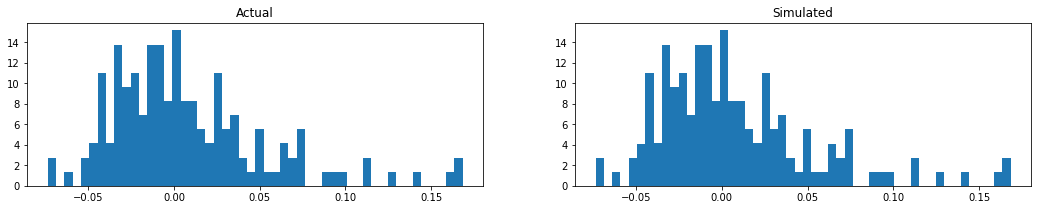

In [10]:
fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(returns, bins=50, density=True)
ax2.hist(simulated_returns.values.flatten(), bins=50, density=True)
ax1.set_title('Actual')
ax2.set_title('Simulated')
plt.show();

# Stats for actual returns

In [11]:
a=perf_stats(returns)
a

Annual return           4.438949
Cumulative returns      1.740353
Annual volatility       0.729732
Sharpe ratio            2.676059
Calmar ratio           22.817198
Stability               0.731435
Max drawdown           -0.194544
Omega ratio             1.602362
Sortino ratio           5.727597
Skew                    1.258839
Kurtosis                1.883611
Tail ratio              2.158368
Daily value at risk    -0.084188
dtype: float64

# Stats for simulated returns (median, max, min)

In [12]:
ratios_for_paths = pd.DataFrame([perf_stats(x[1]) for x in simulated_returns.T.iterrows()])

median

In [13]:
ratios_for_paths.median().T

Annual return           4.357221
Cumulative returns      1.715767
Annual volatility       0.724680
Sharpe ratio            2.670252
Calmar ratio           17.071359
Stability               0.825788
Max drawdown           -0.256758
Omega ratio             1.598489
Sortino ratio           5.698503
Skew                    1.230793
Kurtosis                1.742956
Tail ratio              2.147568
Daily value at risk    -0.083581
dtype: float64

max

In [14]:
ratios_for_paths.max().T

Annual return           1767.315849
Cumulative returns        84.717863
Annual volatility          0.972501
Sharpe ratio               8.915589
Calmar ratio           14167.019311
Stability                  0.994440
Max drawdown              -0.072404
Omega ratio                5.270351
Sortino ratio             31.600308
Skew                       2.398392
Kurtosis                   8.641002
Tail ratio                 4.637924
Daily value at risk       -0.052087
dtype: float64

min

In [15]:
ratios_for_paths.min().T

Annual return         -9.328269e-01
Cumulative returns    -7.995981e-01
Annual volatility      4.670855e-01
Sharpe ratio          -4.856823e+00
Calmar ratio          -1.489253e+00
Stability              7.888873e-14
Max drawdown          -8.212113e-01
Omega ratio            4.684988e-01
Sortino ratio         -5.966232e+00
Skew                   1.853453e-01
Kurtosis              -9.123726e-01
Tail ratio             8.588085e-01
Daily value at risk   -1.111394e-01
dtype: float64

# Probability that max drawdown less than x

In [27]:
x = -.4
len(ratios_for_paths[ratios_for_paths['Max drawdown'] < x]) / number_of_paths

0.080496

# Probability that Sharpe lower than y

In [17]:
y = 1.5
len(ratios_for_paths[ratios_for_paths['Sharpe ratio'] < y]) / number_of_paths

0.16618

# Probability that annual return less than z

In [18]:
z = 2
len(ratios_for_paths[ratios_for_paths['Annual return'] < z]) / number_of_paths

0.26028

# Distributions

Max drawdown

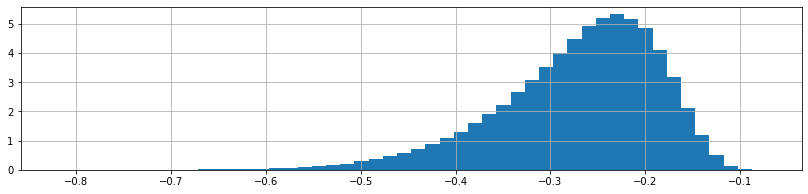

In [19]:
ratios_for_paths['Max drawdown'].hist(bins=50, figsize=(14,3), density=True);

Sharpe

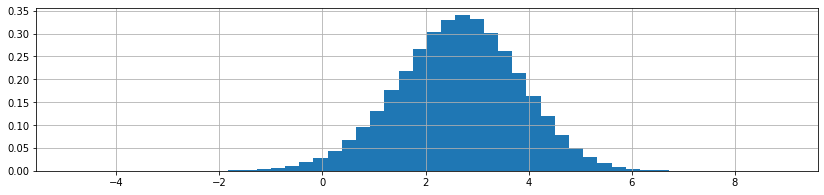

In [20]:
ratios_for_paths['Sharpe ratio'].hist(bins=50, figsize=(14,3), density=True);

Annual return

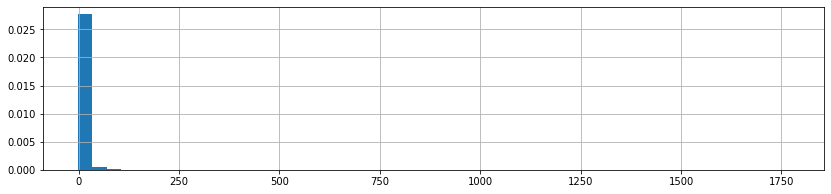

In [21]:
ratios_for_paths['Annual return'].hist(bins=50, figsize=(14,3), density=True);